In [1]:
import sys
import pandas as pd
import numpy as np
import os
from functools import reduce
import datetime
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import (
    auc,
    accuracy_score,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    average_precision_score,
)

sys.path.append("..")

from cyclops.feature_handler import FeatureHandler
from drift_detector.explainer import ShiftExplainer
from experiments import *
from utils.constants import *
from utils.plot_utils import errorfill, plot_roc, plot_pr, linestyles, markers, colors, brightness, colorscale
from utils.utils import run_shift_experiment, get_gemini_data, import_dataset_hospital, get_dataset_hospital, reshape_inputs
from baseline_models.static.utils import run_model

2022-07-07 14:17:09,647 INFO cyclops.orm     - Database setup, ready to run queries!


# Config Parameters #

In [2]:
PATH = "/mnt/nfs/project/delirium/drift_exp/JULY-04-2022"
DATASET = "gemini"
SAMPLES = [10, 20, 50, 100, 200, 500, 1000]
RANDOM_RUNS = 5
SIGN_LEVEL = 0.05
CALC_ACC = True
TIMESTEPS = 6
AGGREGATION_TYPE = "time"
SCALE=True
DR_TECHNIQUES = ["NoRed"]#["NoRed","SRP", "PCA", "kPCA", "Isomap","BBSDs_FFNN","BBSDs_LSTM"]
MD_TESTS = ["MMD"]#["LSDD", "MMD", "LK","Classifier"]

# Query Data

In [3]:
admin_data, x, y = get_gemini_data(PATH)

2022-07-07 14:17:09,879 INFO cyclops.utils.file - Loading dataframe to /mnt/nfs/project/delirium/drift_exp/JULY-04-2022/aggregated_events.parquet


Load data from aggregated events...


2022-07-07 14:17:10,273 INFO cyclops.utils.file - Loading dataframe to /mnt/nfs/project/delirium/drift_exp/JULY-04-2022/aggmeta_start_ts.parquet
2022-07-07 14:17:10,410 INFO cyclops.feature_handler - Loading features from file...
2022-07-07 14:17:10,412 INFO cyclops.feature_handler - Found file to load for static features...
2022-07-07 14:17:10,413 INFO cyclops.feature_handler - Successfully loaded static features from file...
2022-07-07 14:17:10,444 INFO cyclops.feature_handler - Found file to load for temporal features...


Load data from feature handler...


2022-07-07 14:17:15,494 INFO cyclops.feature_handler - Successfully loaded temporal features from file...


Load data from admin data...


2022-07-07 14:17:24,108 INFO cyclops.utils.file - Loading dataframe to /mnt/nfs/project/delirium/drift_exp/JULY-04-2022/aggmeta_end_ts.parquet


# Input Parameters #

In [4]:
SHIFT = input("Select experiment: ")  # covid,seasonal,hosp_type
OUTCOME = input("Select outcome variable: ") # mortality
if SHIFT != "hosp_type":
    HOSPITAL = input("Select hospital: ") # SMH,MSH,UHNTG,UHNTW,PMH
    HOSPITAL = HOSPITAL.split(',')

if SHIFT == "covid":
    EXPERIMENTS = ["pre-covid", "covid"]
    HOSPITAL= ["SMH","MSH","UHNTG","UHNTW","PMH"]

if SHIFT == "seasonal":
    EXPERIMENTS = ["summer", "winter", "seasonal"] #SMH,MSH,THPC,THPM,UHNTG,UHNTW,PMH

if SHIFT == "hosp_type":
    EXPERIMENTS = ["academic", "community", "hosp_type"]
    HOSPITAL = ["SMH","MSH","THPC","THPM","UHNTG","UHNTW","PMH"]


Select experiment:  covid
Select outcome variable:  mortality
Select hospital:  SMH,MSH,THPC,THPM,UHNTG,UHNTW,PMH


# Drift Tests #

In [5]:
# Run shift experiments
if os.path.exists(os.path.join(PATH, '_'.join([SHIFT, '_'.join(HOSPITAL),"mean_dr_md_pval.pkl"]))):
    with open(os.path.join(PATH, '_'.join([SHIFT, '_'.join(HOSPITAL),"mean_dr_md_pval.pkl"])), "rb") as f:
        mean_dr_md_pval = pickle.load(f)
    with open(os.path.join(PATH, '_'.join([SHIFT, '_'.join(HOSPITAL),"mean_dr_md_dist.pkl"])), "rb") as f:
        mean_dr_md_dist = pickle.load(f)
else:
    mean_dr_md_pval = np.ones(
        (len(EXPERIMENTS), len(DR_TECHNIQUES), len(MD_TESTS), len(SAMPLES))
    ) * (-1)
    mean_dr_md_dist = np.ones(
        (len(EXPERIMENTS), len(DR_TECHNIQUES), len(MD_TESTS), len(SAMPLES))
    ) * (-1)

if os.path.exists(os.path.join(PATH, '_'.join([SHIFT, '_'.join(HOSPITAL),"std_dr_md_pval.pkl"]))):
    with open(os.path.join(PATH, '_'.join([SHIFT, '_'.join(HOSPITAL),"std_dr_md_pval.pkl"])), "rb") as f:
        std_dr_md_pval = pickle.load(f)
    with open(os.path.join(PATH, '_'.join([SHIFT, '_'.join(HOSPITAL),"std_dr_md_dist.pkl"])), "rb") as f:
        std_dr_md_dist = pickle.load(f)
        
else:
    std_dr_md_pval = np.ones(
        (len(EXPERIMENTS), len(DR_TECHNIQUES), len(MD_TESTS), len(SAMPLES))
    ) * (-1)
    std_dr_md_dist = np.ones(
        (len(EXPERIMENTS), len(DR_TECHNIQUES), len(MD_TESTS), len(SAMPLES))
    ) * (-1)


for si, SHIFT in enumerate(EXPERIMENTS):
    for di, DR_TECHNIQUE in enumerate(DR_TECHNIQUES):
        for mi, MD_TEST in enumerate(MD_TESTS):
            if np.any(mean_dr_md_pval[si, di, mi, :] == -1):
                print(
                    "{} | {} | {} | {}".format(
                        SHIFT, HOSPITAL, DR_TECHNIQUE, MD_TEST
                    )
                )
                try:
                    mean_p_vals, std_p_vals, mean_dist, std_dist = run_shift_experiment(
                        shift=SHIFT,
                        admin_data=admin_data,
                        x=x, 
                        y=y,
                        outcome=OUTCOME,
                        hospital=HOSPITAL,
                        path=PATH,
                        aggregation_type=AGGREGATION_TYPE,
                        scale=SCALE,
                        dr_technique=DR_TECHNIQUE,
                        md_test=MD_TEST,
                        samples=SAMPLES,
                        dataset=DATASET,
                        sign_level=SIGN_LEVEL,
                        timesteps=TIMESTEPS,
                        random_runs=RANDOM_RUNS,
                        calc_acc=CALC_ACC
                    )
                    
                    mean_dr_md_pval[si, di, mi, :] = mean_p_vals
                    std_dr_md_pval[si, di, mi, :] = std_p_vals
                    mean_dr_md_dist[si, di, mi, :] = mean_dist
                    std_dr_md_dist[si, di, mi, :] = std_dist
                except ValueError as e:
                    print("Value Error")
                    pass

2022-07-07 14:18:08,560 INFO cyclops.feature_handler - Loading features from file...
2022-07-07 14:18:08,562 INFO cyclops.feature_handler - Found file to load for static features...
2022-07-07 14:18:08,563 INFO cyclops.feature_handler - Successfully loaded static features from file...
2022-07-07 14:18:08,600 INFO cyclops.feature_handler - Found file to load for temporal features...


pre-covid | ['SMH', 'MSH', 'UHNTG', 'UHNTW', 'PMH'] | NoRed | MMD


2022-07-07 14:18:13,523 INFO cyclops.feature_handler - Successfully loaded temporal features from file...
2022-07-07 14:18:22,205 INFO cyclops.feature_handler - Loading features from file...
2022-07-07 14:18:22,206 INFO cyclops.feature_handler - Found file to load for static features...
2022-07-07 14:18:22,207 INFO cyclops.feature_handler - Successfully loaded static features from file...
2022-07-07 14:18:22,236 INFO cyclops.feature_handler - Found file to load for temporal features...


covid | ['SMH', 'MSH', 'UHNTG', 'UHNTW', 'PMH'] | NoRed | MMD


2022-07-07 14:18:27,149 INFO cyclops.feature_handler - Successfully loaded temporal features from file...


Select Pre-Processing:  NoRed
Select Two-Sample Testing:  MMD


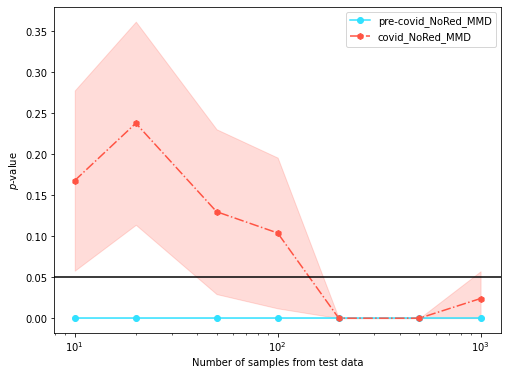

In [6]:
DIM_RED = input("Select Pre-Processing: ")
MD_TEST = input("Select Two-Sample Testing: ")

fig = plt.figure(figsize=(8, 6))
for si, shift in enumerate(EXPERIMENTS):
    for di, dr_technique in enumerate(DR_TECHNIQUES):
        for mi, md_test in enumerate(MD_TESTS):
            if (
                    dr_technique == DIM_RED
                    and md_test == MD_TEST
            ):
                errorfill(
                        np.array(SAMPLES),
                        mean_dr_md_pval[si, di, mi, :],
                        std_dr_md_pval[si, di, mi, :],
                        fmt=linestyles[si] + markers[si],
                        color=colorscale(colors[si], brightness[si]),
                        label="%s" % "_".join([shift, dr_technique, md_test]),
                )
plt.xlabel("Number of samples from test data")
plt.ylabel("$p$-value")
plt.axhline(y=SIGN_LEVEL, color="k")
plt.legend()
plt.show()

# Run shift experiments
if not os.path.exists(os.path.join(PATH, '_'.join([SHIFT, '_'.join(HOSPITAL),"mean_dr_md_pval.pkl"]))):
    with open(os.path.join(PATH, '_'.join([SHIFT, '_'.join(HOSPITAL),"mean_dr_md_pval.pkl"])), "wb") as f:
        pickle.dump(mean_dr_md_pval, f)
    with open(os.path.join(PATH, '_'.join([SHIFT, '_'.join(HOSPITAL),"mean_dr_md_dist.pkl"])), "wb") as f:
        pickle.dump(mean_dr_md_dist, f)
if not os.path.exists(os.path.join(PATH, '_'.join([SHIFT, '_'.join(HOSPITAL),"std_dr_md_pval.pkl"]))):
    with open(os.path.join(PATH, '_'.join([SHIFT, '_'.join(HOSPITAL),"std_dr_md_pval.pkl"])), "wb") as f:
        pickle.dump(std_dr_md_pval, f)
    with open(os.path.join(PATH, '_'.join([SHIFT, '_'.join(HOSPITAL),"std_dr_md_dist.pkl"])), "wb") as f:
        pickle.dump(std_dr_md_dist, f)

# Build Model #

In [ ]:
(X_tr, y_tr), (X_val, y_val), (X_t, y_t), feats, orig_dims, admin_data = import_dataset_hospital(admin_data, x, y, SHIFT, OUTCOME, HOSPITAL, 1, shuffle=True)

MODEL_NAME = input("Select Model: ")
MODEL_PATH = PATH + "_".join([SHIFT, OUTCOME, '_'.join(HOSPITAL), MODEL_NAME]) + ".pkl"
if os.path.exists(MODEL_PATH):
    optimised_model = pickle.load(open(MODEL_PATH, "rb"))
else:
    optimised_model = run_model(MODEL_NAME, X_tr, y_tr, X_val, y_val)

### Performance on Source Data ###

<AxesSubplot:title={'center':'Average Precision: 0.962282'}, xlabel='Recall', ylabel='Precision'>

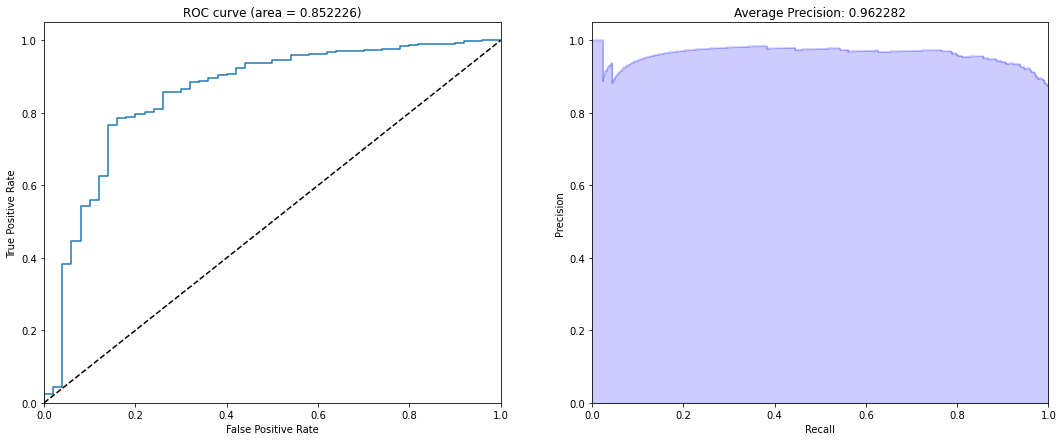

In [17]:
y_pred_prob = optimised_model.predict_proba(X_val)[:, 1]

fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob, pos_label=1)
roc_auc = auc(fpr, tpr)
precision, recall, thresholds = precision_recall_curve(y_val, y_pred_prob)
avg_pr = average_precision_score(y_val, y_pred_prob)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 7))
plot_roc(ax[0], fpr, tpr, roc_auc)
plot_pr(ax[1], recall, precision, avg_pr)

### Performance on Target Data ###

<AxesSubplot:title={'center':'Average Precision: 0.913662'}, xlabel='Recall', ylabel='Precision'>

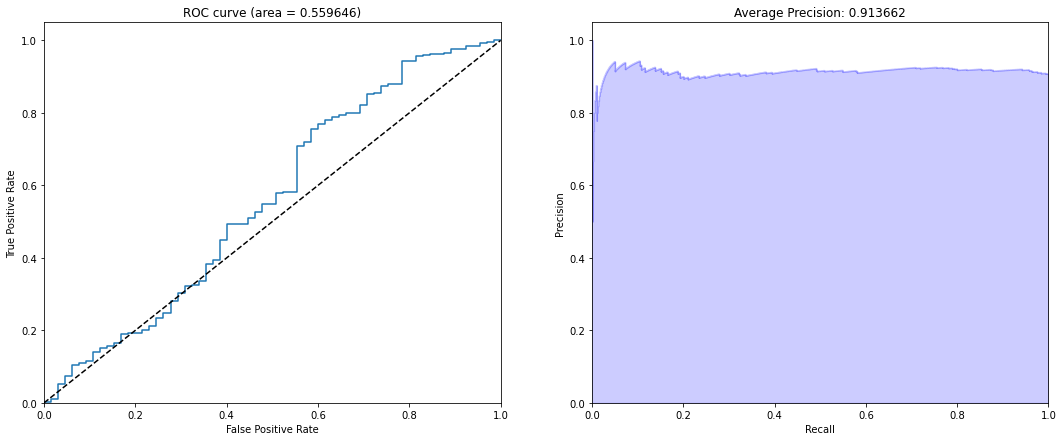

In [18]:
y_pred_prob = optimised_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob, pos_label=1)
roc_auc = auc(fpr, tpr)
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
avg_pr = average_precision_score(y_test, y_pred_prob)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 7))
plot_roc(ax[0], fpr, tpr, roc_auc)
plot_pr(ax[1], recall, precision, avg_pr)

## Performance by Sample Size ##

In [19]:
samp_metrics = np.ones((len(SAMPLES), RANDOM_RUNS, 2, 2)) * (-1)
for si, sample in enumerate(SAMPLES):
    for i in range(0, RANDOM_RUNS - 1):
        i = int(i)
        np.random.seed(i)
        X_val, y_val = unison_shuffled_copies(X_val, y_val)
        X_test, y_test = unison_shuffled_copies(X_test, y_test)

        y_val_pred_prob = optimised_model.predict_proba(X_val[:sample])[:, 1]
        val_fpr, val_tpr, val_thresholds = roc_curve(
            y_val[:sample], y_val_pred_prob, pos_label=1
        )
        val_roc_auc = auc(val_fpr, val_tpr)
        val_avg_pr = average_precision_score(y_val[:sample], y_val_pred_prob)

        y_test_pred_prob = optimised_model.predict_proba(X_test[:sample])[:, 1]
        test_fpr, test_tpr, test_thresholds = roc_curve(
            y_test[:sample], y_test_pred_prob, pos_label=1
        )
        test_roc_auc = auc(test_fpr, test_tpr)
        test_avg_pr = average_precision_score(y_test[:sample], y_test_pred_prob)

        samp_metrics[si, i, 0, :] = [val_roc_auc, val_avg_pr]
        samp_metrics[si, i, 1, :] = [test_roc_auc, test_avg_pr]

    mean_samp_metrics = np.mean(samp_metrics, axis=1)
    std_samp_metrics = np.std(samp_metrics, axis=1)

torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
No negative samples in y_true, false positive value should be meaningless
No negative samples in y_true, false positive value should be meaningless
No negative samples in y_true, false positive value should be meaningless
No negative samples in y_true, false positive value should be meaningless
No negative samples in y_true, false positive value should be meaningless
torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
torch.range is deprecated and will b

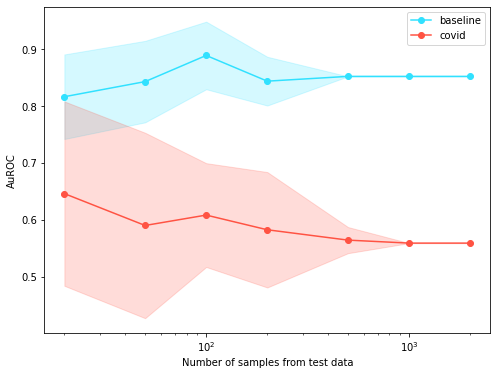

In [21]:
fig = plt.figure(figsize=(8, 6))
for si, shift in enumerate(["baseline", SHIFT]):
    for mi, metric in enumerate(["AuROC", "Avg Pr"]):
        if metric == "AuROC":
            errorfill(
                np.array(SAMPLES[1:]),
                mean_samp_metrics[1:, si, mi],
                std_samp_metrics[1:, si, mi],
                fmt=linestyles[mi] + markers[mi],
                color=colorscale(colors[si], brightness[si]),
                label="%s" % "_".join([shift]),
            )
plt.xlabel("Number of samples from test data")
plt.ylabel("AuROC")
plt.legend()
plt.show()

## Explain Difference in Model Predictions ## 

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


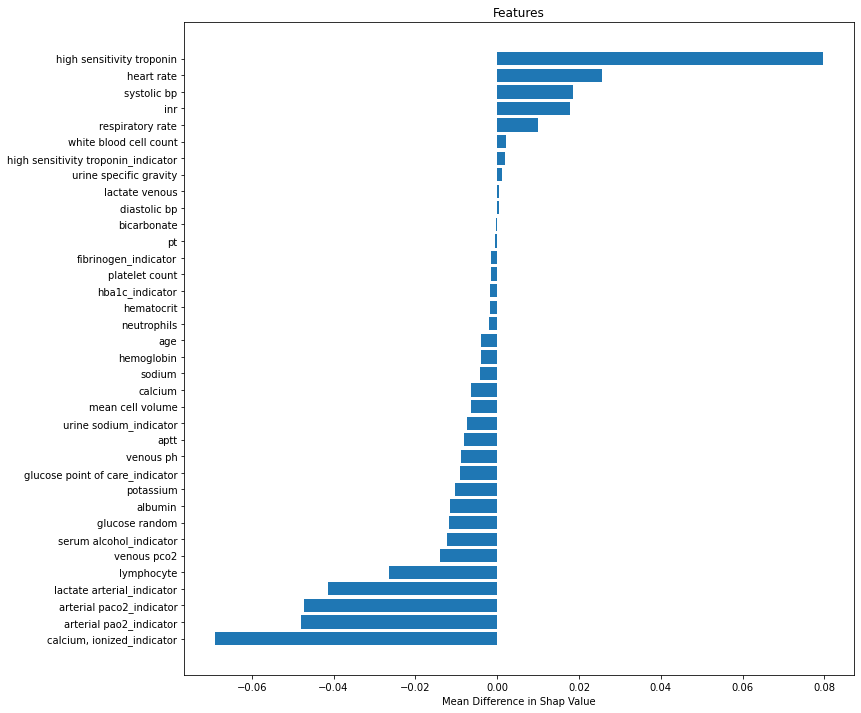

In [22]:
explainer = ShiftExplainer(optimised_model)
explainer.get_explainer()

X_val_df = pd.DataFrame(X_val, columns=feats)
val_shap_values = explainer.get_shap_values(X_val_df)
X_test_df = pd.DataFrame(X_test, columns=feats)
test_shap_values = explainer.get_shap_values(X_test_df)

diff = np.mean(np.abs(test_shap_values.values), axis=0) - np.mean(
    np.abs(val_shap_values.values), axis=0
)
diff_sorted, feats_sorted = zip(*sorted(zip(diff, feats), reverse=True))
diff_sorted, feats_sorted = zip(
    *(((x, y) for x, y in zip(diff_sorted, feats_sorted) if x != 0))
)
fig, ax = plt.subplots(figsize=(12, 12))
y_pos = np.arange(len(diff_sorted))
ax.barh(y_pos, diff_sorted, align="center")
ax.set_yticks(y_pos, labels=feats_sorted)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel("Mean Difference in Shap Value")
ax.set_title("Features")
plt.show()

## Debugging cause what in the world is happening

In [35]:
from sklearn.preprocessing import StandardScaler
from alibi_detect.cd import MMDDrift

sys.path.append("..")

from drift_detector.detector import ShiftDetector
from drift_detector.reductor import ShiftReductor

SHIFT="test"
scale=True
sample=100
dr_technique="NoRed"
md_test="MMD"
aggregation_type="time"
timesteps=6

feature_handler = FeatureHandler()
feature_handler.load(PATH, "features")

# Get types of columns
numerical_cols = feature_handler.get_numerical_feature_names()["temporal"]
numerical_cols += ["age"]

    
(X_tr, y_tr), (X_val, y_val), (X_t, y_t), feats, orig_dims, admin_data = import_dataset_hospital(admin_data, x, y, SHIFT, OUTCOME, HOSPITAL, 1, shuffle=True)

if aggregation_type == "mean":
    X_tr_normalized = X_tr.groupby(level=[0]).mean()
    X_val_normalized = X_val.groupby(level=[0]).mean()
    X_t_normalized = X_t.groupby(level=[0]).mean()     
elif aggregation_type == "first":
    X_tr_normalized = X_tr.groupby(level=[0]).first()
    X_val_normalized = X_val.groupby(level=[0]).first()
    X_t_normalized = X_t.groupby(level=[0]).first()    
elif aggregation_type == "last":
    X_tr_normalized = X_tr.groupby(level=[0]).last()
    X_val_normalized = X_val.groupby(level=[0]).last()
    X_t_normalized = X_t.groupby(level=[0]).last()   
elif aggregation_type == "time_flatten" or aggregation_type == "time":
    X_tr_normalized = X_tr.copy()
    X_val_normalized = X_val.copy()
    X_t_normalized = X_t.copy()
else:
    raise ValueError("Incorrect Aggregation Type")

if scale:
    for col in numerical_cols:
        scaler = StandardScaler().fit(X_tr_normalized[col].values.reshape(-1, 1))
        X_tr_normalized[col] = pd.Series(
            np.squeeze(scaler.transform(X_tr_normalized[col].values.reshape(-1, 1))),
            index=X_tr_normalized[col].index,
        )
        X_val_normalized[col] = pd.Series(
            np.squeeze(scaler.transform(X_val_normalized[col].values.reshape(-1, 1))),
            index=X_val_normalized[col].index,
        )
        X_t_normalized[col] = pd.Series(
            np.squeeze(scaler.transform(X_t_normalized[col].values.reshape(-1, 1))),
            index=X_t_normalized[col].index,
        )

if aggregation_type == "time_flatten":
    X_tr_input = X_tr_normalized.unstack(1).dropna().to_numpy()
    X_val_input = X_val_normalized.unstack(1).dropna().to_numpy()
    X_t_input = X_t_normalized.unstack(1).dropna().to_numpy()
elif aggregation_type == "time":
    X_tr_input = reshape_inputs(X_tr_normalized, timesteps)
    X_val_input = reshape_inputs(X_val_normalized, timesteps)
    X_t_input = reshape_inputs(X_t_normalized, timesteps)
else:
    X_tr_input = X_tr_normalized.dropna().to_numpy()
    X_val_input = X_val_normalized.dropna().to_numpy()
    X_t_input = X_t_normalized.dropna().to_numpy()

X_tr_final = X_tr_input.copy()
X_val_final = X_val_input.copy()
X_t_final = X_t_input.copy()

shift_reductor = ShiftReductor(
            X_tr_final, y_tr, dr_technique, orig_dims, DATASET, var_ret=0.8, model=None
)

shift_detector = ShiftDetector(
                dr_technique, md_test, SIGN_LEVEL, shift_reductor, sample, DATASET, feats,
)

(p_val,
 dist,
 val_acc,
 te_acc,
) = shift_detector.detect_data_shift(
                X_tr_final, y_tr, X_val_final, y_val, X_t_final[:sample,:], y_t[:sample], orig_dims
)

X_tr_final.shape, X_val_final.shape, X_t_final.shape

p_val

cd = MMDDrift(X_val_final, backend='pytorch', p_val=.05)
preds = cd.predict(X_t_final, return_p_val=True, return_distance=True)

preds

2022-07-07 13:40:48,080 INFO cyclops.feature_handler - Loading features from file...
2022-07-07 13:40:48,083 INFO cyclops.feature_handler - Found file to load for static features...
2022-07-07 13:40:48,084 INFO cyclops.feature_handler - Successfully loaded static features from file...
2022-07-07 13:40:48,115 INFO cyclops.feature_handler - Found file to load for temporal features...
2022-07-07 13:40:53,122 INFO cyclops.feature_handler - Successfully loaded temporal features from file...


0.0